In [108]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [109]:
file_paths = [f for f in glob.glob("*") if f.endswith('.pickle')]

result = {}
for pckl in file_paths:
    result.update(pd.read_pickle(pckl))

In [118]:
# Show different pickle files
file_paths

['data_set_results_ibm_hr-2.pickle',
 'data_set_results_prt_bank.pickle',
 'data_set_results_ccp.pickle']

In [110]:
# Prepare data set in a shape that we get the overall performance per sampling approach and model
{
    'sampling approach sa': {
        'model mo': {
            'metric me': []
        }
    }
}

{'sampling approach sa': {'model mo': {'metric me': []}}}

In [111]:
# Since all dicts have the same structure I just take the first one
models = result['ibm_hr'].keys()
sampling_approaches = result['ibm_hr']['lr'].keys()
shaped_results = dict.fromkeys(sampling_approaches, dict.fromkeys(models,[]))

In [119]:
# Sanity check - To check if transformation works fine
sanity_check = np.mean(
    result['ibm_hr']['lr']['no_sampling']['test_roc_auc'].tolist() +
    result['ccp']['lr']['no_sampling']['test_roc_auc'].tolist() +
    result['prt_bank']['lr']['no_sampling']['test_roc_auc'].tolist()
)
sanity_check

0.853049936500429

In [120]:
def list_conv(l):
    # if l is not a list (assuming its an array) then convert it
    return l.tolist() if type(l) is not list else l

def metric_merger(d1, d2):
    agg = dict.fromkeys(d1.keys(),[])
    
    for k,v in d1.items():
        agg[k] = agg[k] + list_conv(d1[k]) + list_conv(d2[k])
    return agg

# To store the restructured dict
prf = {}

for ds in result.keys():
    for m in result[ds].keys():
        for sa in result[ds][m].keys():
            
            if sa in prf:
                if m in prf[sa]:
                    prf[sa][m]=metric_merger(prf[sa][m],result[ds][m][sa])
                else:
                    prf[sa][m] = result[ds][m][sa]
            else:
                prf[sa] = {}
                prf[sa][m] = result[ds][m][sa]          

In [124]:
# Same as sanity check above
np.mean(prf['no_sampling']['lr']['test_roc_auc'])

0.853049936500429

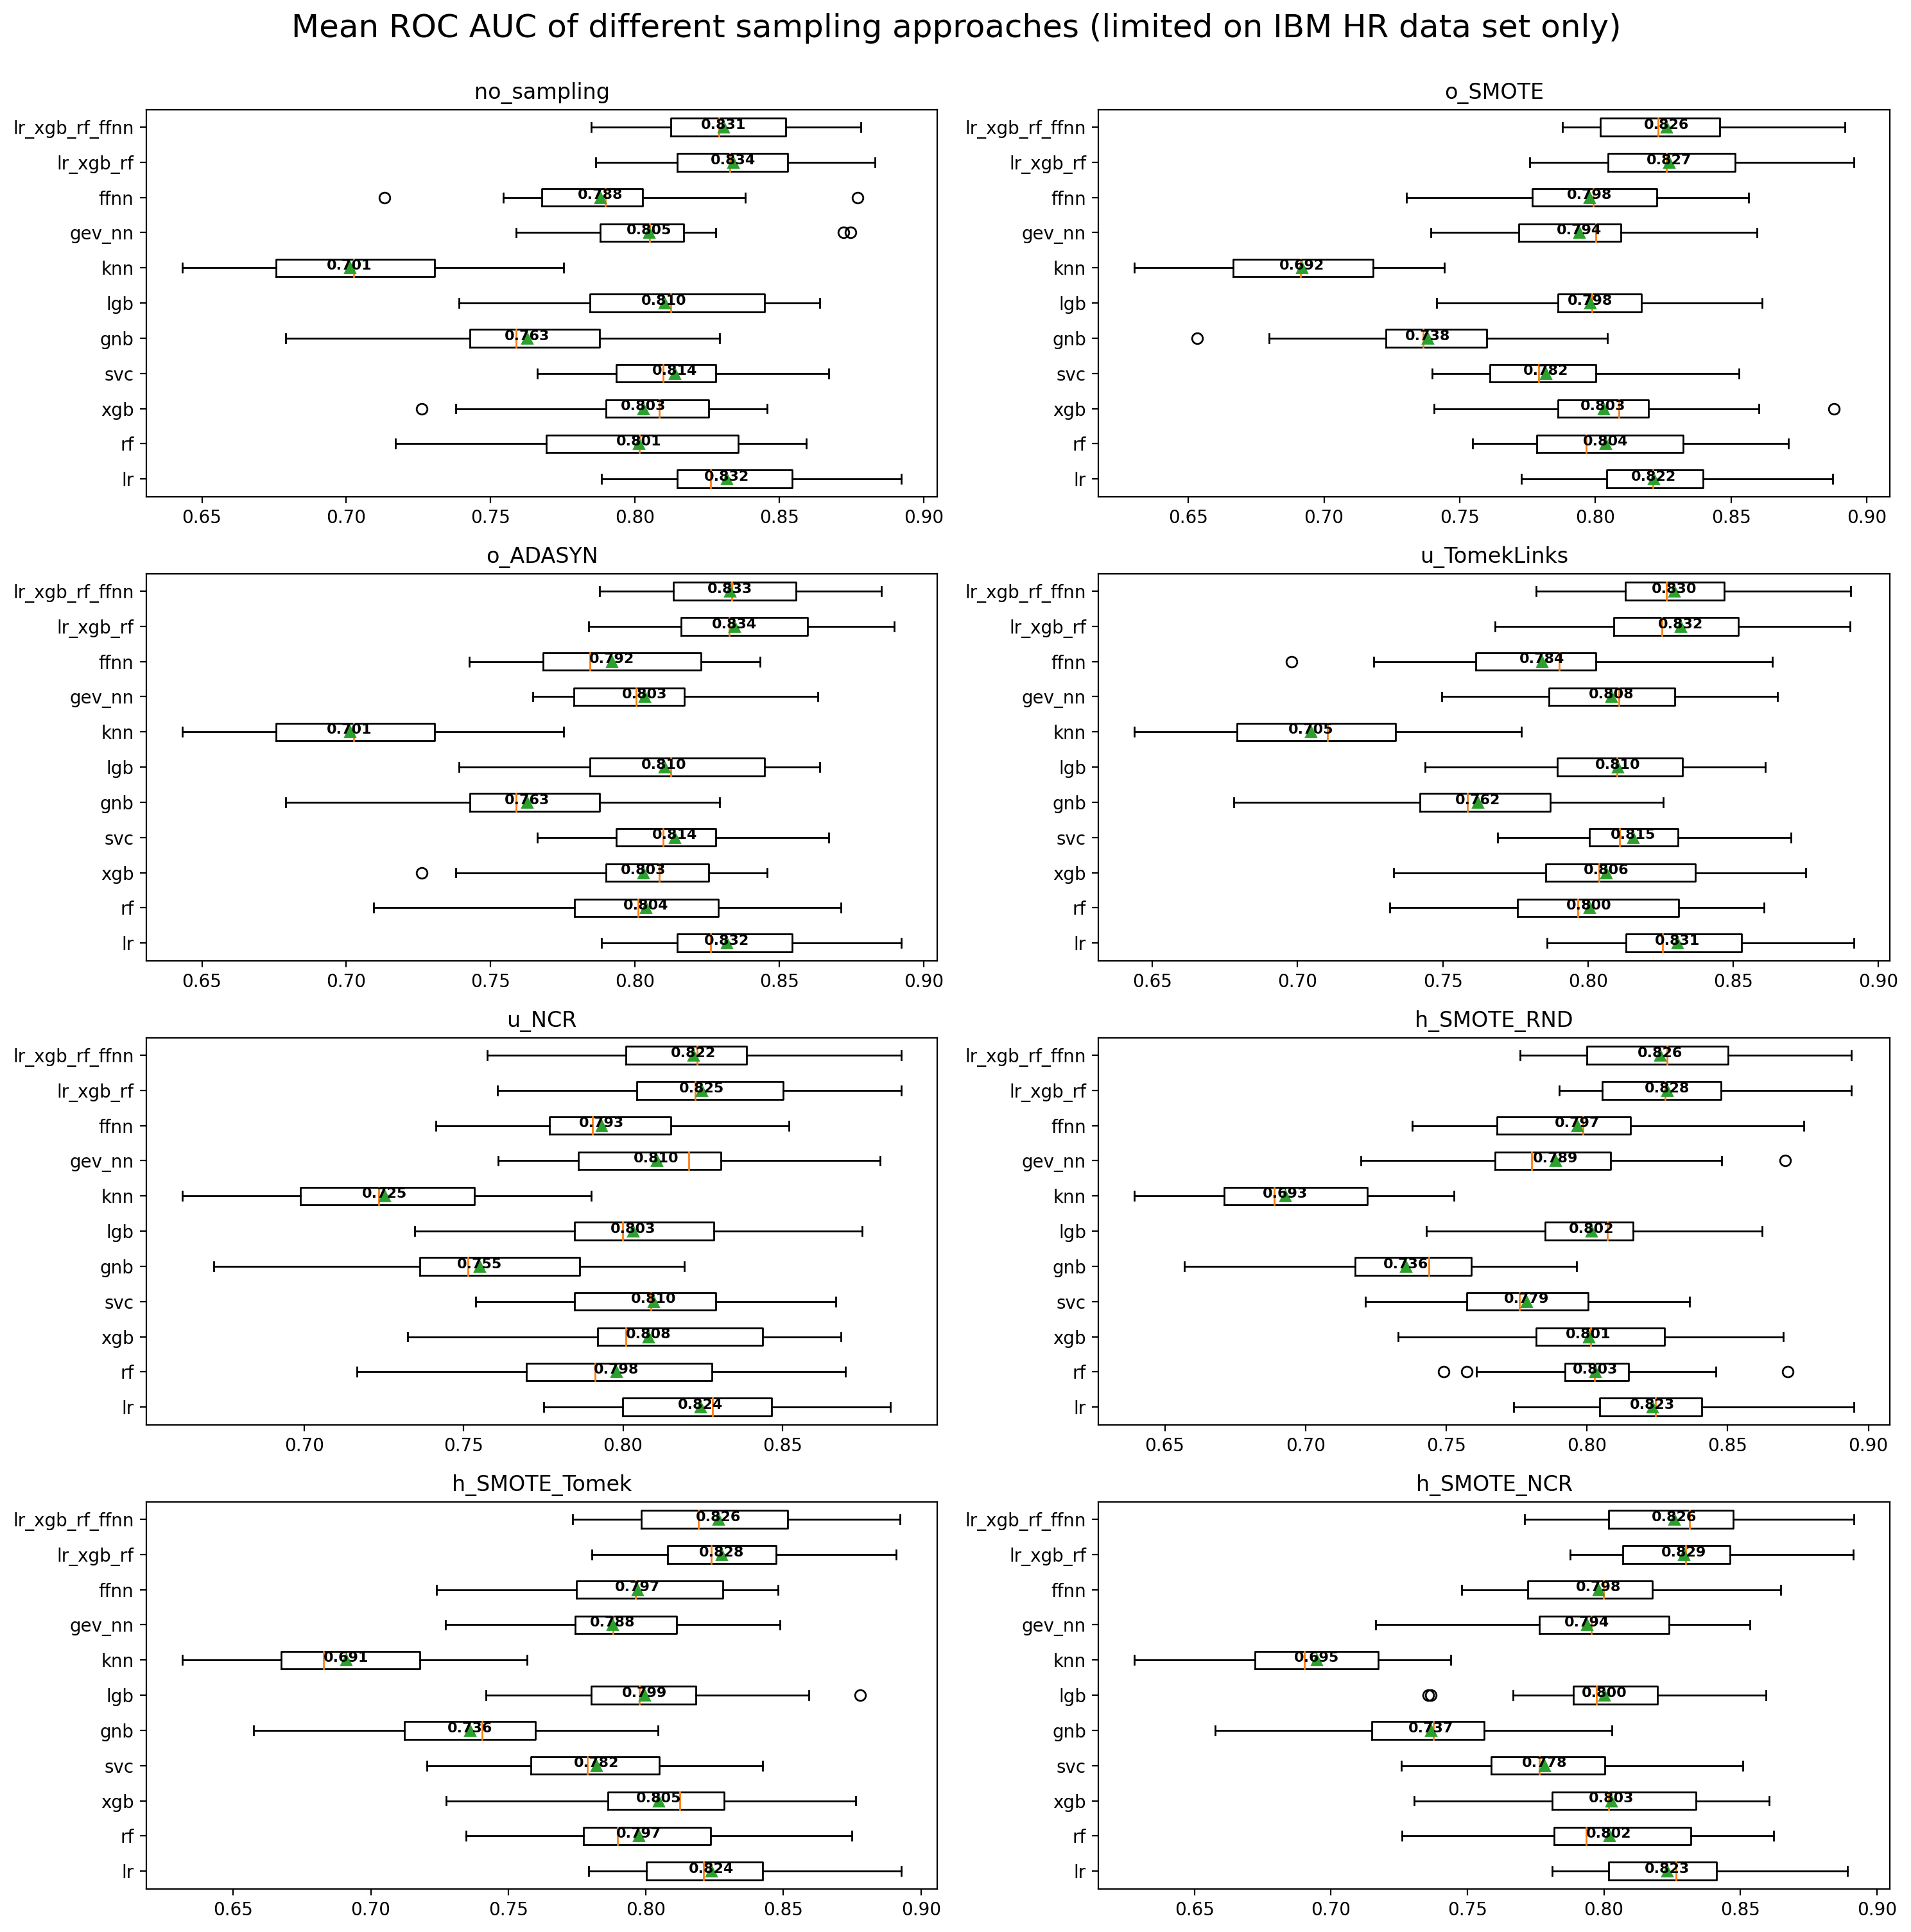

In [117]:
def plot_comparision_chart(values, labels, sampling_approach, 
                           ylabel='ROC AUC', nrows=1, ncols=1, n=1):
    
    # Create axes object
    ax = plt.subplot(nrows, ncols, n + 1)
    bp = plt.boxplot(values, labels=[str(m) for m in labels], 
                     showmeans=True, vert=False)
    
    # Annotate boxplot with mean values
    for line in bp['means']:
        xd = line.get_xdata()[0]
        yd = line.get_ydata()[0]
        coo = line.get_xydata()
        plt.annotate('%.3f' % xd, 
                     [xd, yd-0.05],
                     horizontalalignment='center',
                     fontsize=8,
                     weight='bold'
                    )
    ax.set_title(f"{sampling_approach}")
    return ax


ncols = 2
nrows = len(prf.keys()) // ncols + (len(prf.keys()) % ncols > 0)

fig = plt.figure(figsize=(15,15), dpi=200)

for n, sampling_approach in enumerate(prf.keys()):
    
    # Store values and labels for the axes
    values = []
    labels = []
    
    # Get model's performance for given sampling approach
    for m in models:
        values.append(prf[sampling_approach][m]['test_roc_auc'])
        labels.append(m)
    
    # Create axes object
    plot_comparision_chart(values, labels, sampling_approach, ylabel="ROC AUC", 
                           nrows=nrows, ncols=ncols,n=n)

fig.suptitle("Mean ROC AUC of different sampling approaches (limited on IBM HR data set only)", fontsize=18, y=1)
plt.tight_layout()
plt.show()   